In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

from shapely import wkt


from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes

In [ ]:
import seaborn as jks
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

In [4]:
demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
d23 = pd.read_csv('../../cc_election_cleaning/all_rounds_results/district_23.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')

ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)

full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')
jk = full_results[full_results['candidate'] == 'Jaslin Kaur']


full_results_twenty_three = full_results[full_results['district'] == 23]
winner_twenty_three = full_results_twenty_three[full_results_twenty_three['winner'] == True]
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')
eds_23 = full_results_twenty_three['ed_name'].unique().tolist()
ae = pd.read_csv('../../cc_election_cleaning/ae_precincts.csv')

In [5]:
av = pd.read_csv('../../cc_election_cleaning/additional_variables.csv')
fwe = pd.read_csv('../data/finance_with_ethnicity.csv')
f_plus = pd.read_csv('../../council_campaign_finance/data/iwrl_plus.csv')
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')

In [10]:
p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
wp_cols.remove('w2cop')
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip']
wp_cols = [col for col in wp_cols if col not in to_remove]
demo_cols = ['nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21']

jk = gpd.GeoDataFrame(jk,geometry=jk['geometry'].apply(wkt.loads))
jk = jk.set_crs(epsg=2263, allow_override=True)
co_3857 = jk.to_crs(epsg=3857)

In [ ]:
full_results_twenty_three.groupby('candidate')['vote'].sum().sort_values(ascending=False)

In [4]:
top_three = full_results_twenty_three[full_results_twenty_three['candidate'].isin(['Linda Lee','Jaslin Kaur','Steve Behar'])]
winners = top_three.loc[top_three.groupby('ed_name')['vote_share'].idxmax()].copy()
winners['norm'] = winners.groupby('candidate')['vote_share'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)


In [5]:
winners['candidate'].value_counts()

candidate
Jaslin Kaur    52
Linda Lee      51
Steve Behar     6
Name: count, dtype: int64

In [6]:
def assign_color(row):
    if row['candidate'] == 'Linda Lee':
        return mpl.cm.Blues(row['norm'])
    elif row['candidate'] =='Jaslin Kaur':
        return mpl.cm.Reds(row['norm'])
    else:
        return mpl.cm.Greens(row['norm'])
    
winners['color'] = winners.apply(assign_color, axis=1)

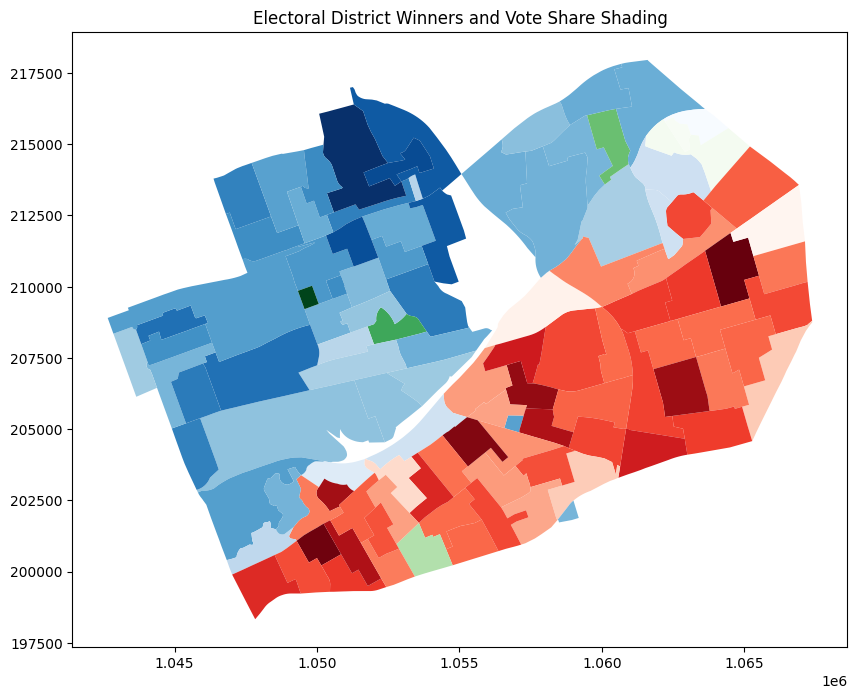

In [7]:
winners = gpd.GeoDataFrame(winners,geometry=winners['geometry'].apply(wkt.loads))

fig, ax = plt.subplots(1, figsize=(10, 10))
winners.plot(color=winners['color'], ax=ax)
ax.set_title("Electoral District Winners and Vote Share Shading")
plt.show()

In [8]:
winner_twenty_three_map = gpd.GeoDataFrame(winner_twenty_three,geometry=winner_twenty_three['geometry'].apply(wkt.loads))

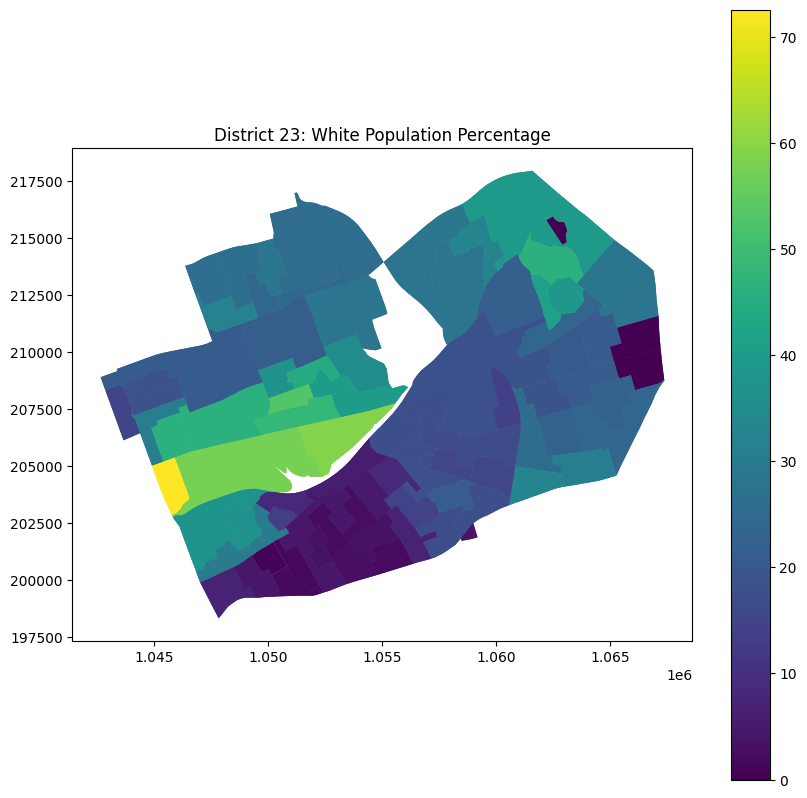

In [23]:
winner_twenty_three_map.plot(column='nhw21p',legend=True,figsize=(10,10),cmap='viridis')
plt.title('District 23: White Population Percentage')
plt.show()

In [14]:
eth_cols = ['ind21p','bang21p','chin21p','filip21p','kor21p','nep21p','pak21p','sril21p','taiw21p','thai21p','viet21p']

In [15]:
winners[['candidate','ed_name']].merge(ae,left_on='ed_name',right_on='ElectDist').groupby('candidate')[eth_cols].mean()    

,ind21p,bang21p,chin21p,filip21p,kor21p,nep21p,pak21p,sril21p,taiw21p,thai21p,viet21p
candidate,,,,,,,,,,,
Jaslin Kaur,23.593822,3.605697,4.403801,4.713797,1.078447,0.055856,1.774505,0.214822,0.063402,0.112231,0.060349
Linda Lee,4.681178,0.516295,21.171735,1.876085,8.360457,0.100585,0.784719,0.107429,0.618660,0.070125,0.232904
Steve Behar,4.163214,0.244519,17.025207,0.977580,4.119338,0.031697,0.238244,0.000000,0.288929,0.339253,0.129144


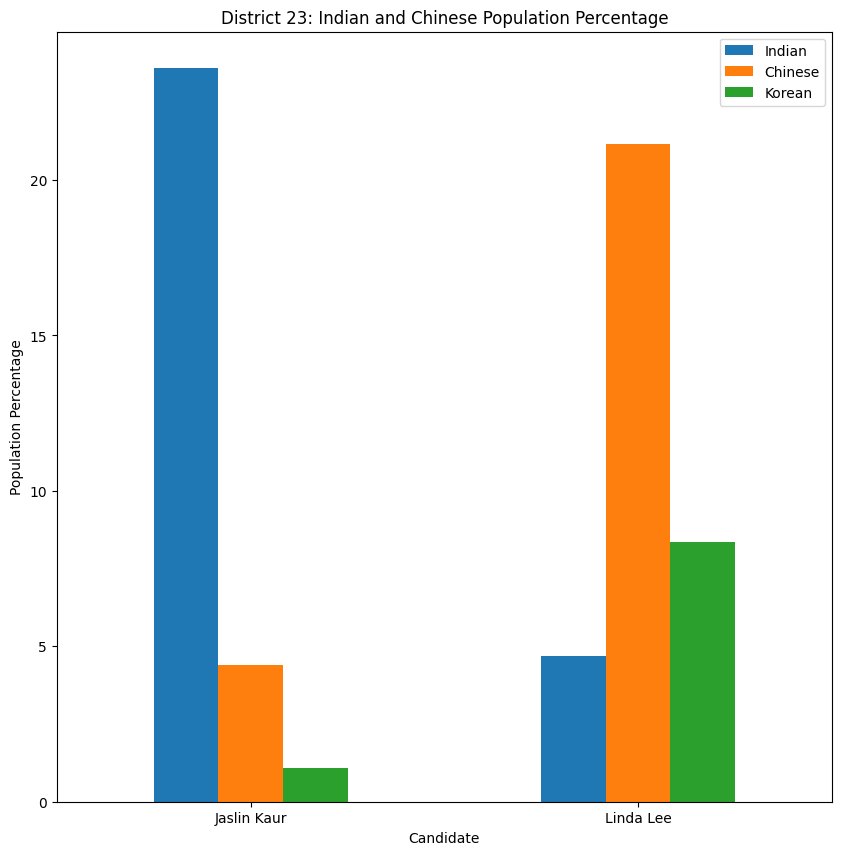

In [21]:
eth_group = winners[['candidate','ed_name']].merge(ae,left_on='ed_name',right_on='ElectDist')\
    .groupby('candidate')[['ind21p','chin21p','kor21p']].mean().reset_index()

filtered_data = eth_group[eth_group['candidate'].isin(['Linda Lee','Jaslin Kaur'])]

filtered_data.plot(x='candidate', kind='bar', figsize=(10,10))
plt.title('District 23: Indian and Chinese Population Percentage')
plt.xlabel('Candidate') 
plt.ylabel('Population Percentage')  
plt.legend(['Indian','Chinese','Korean'])
plt.xticks(rotation=0) 
plt.show()

Correlations and EFA

In [35]:
demo_occ = jk[['vote_share','ed_name','nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21','venez21p','chin21p',
                 'kor21p','colomb21p','domin21p','prican21p','mex21p','white_transplant_ratio','adams213p','winda21p']].merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')
demo_occ = demo_occ.merge(ae[['ElectDist','ind21p','bang21p','pak21p','filip21p']],on = 'ElectDist',how='left')
demo_occ = demo_occ.merge(av,on='ElectDist',how='left')

In [36]:
demo_occ['log_mhhi21'] = np.log(demo_occ['mhhi21'])

c:\Users\samtg\github\member_chapters\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [52]:
test_cols = ['nhw21p','nhb21p','h21p','nha21p','cvap21bapp','venez21p','chin21p','kor21p','colomb21p','domin21p','prican21p',
'mex21p','white_transplant_ratio','ind21p','bang21p','pak21p','filip21p','greek21p','arab21p',
'fb21bdp','fb21drp','hh21bop','adams213p'] + wp_cols

In [38]:
cor_matrix = demo_occ[test_cols].corr()
cor_matrix.dropna(subset=('vote_share'),inplace=True)
cor_matrix.sort_values(by='vote_share', ascending=False)

,vote_share,nhw21p,nhb21p,h21p,nha21p,cvap21bapp,log_mhhi21,venez21p,chin21p,kor21p,...,w2bgp,w2pservep,w2salep,w2oadp,w2farmp,w2conp,w2emrp,w2prodp,w2tranp,w2matp
vote_share,1.000000,-0.453296,0.351847,0.382101,-0.166459,-0.323137,0.212347,-0.066571,-0.654928,-0.504249,...,0.455015,-0.027130,-0.135052,0.126195,0.137855,0.059350,-0.066749,0.182676,0.317296,0.288762
ind21p,0.588196,-0.292222,-0.099918,0.026329,0.085793,-0.194246,-0.142398,-0.103037,-0.527621,-0.501242,...,0.423092,-0.293580,-0.172419,0.191042,0.304546,0.129037,-0.176763,0.069453,0.201504,0.146548
fb21bdp,0.549128,-0.475434,0.336867,0.383027,-0.130390,-0.301205,0.126398,-0.089392,-0.547407,-0.510010,...,0.260050,0.060449,-0.229371,0.354445,0.254450,-0.000814,0.016504,0.208389,0.357468,0.403998
filip21p,0.513635,-0.382405,0.225264,0.377901,-0.143598,-0.247716,0.098853,0.053418,-0.577641,-0.539071,...,0.204761,-0.078738,-0.130039,0.179511,0.189733,0.106920,-0.048797,0.285467,0.216758,0.141729
hh21bop,0.492123,-0.074903,0.051080,0.231481,-0.218249,-0.060444,-0.032555,0.189562,-0.524341,-0.566471,...,0.439217,-0.111583,-0.210683,0.000433,0.011003,0.085437,-0.185380,0.129361,0.215650,0.189541
w2bgp,0.455015,-0.390036,0.130698,0.354154,-0.190239,-0.217416,-0.112545,-0.109793,-0.417705,-0.341203,...,1.000000,-0.098729,0.040856,0.114820,-0.071218,-0.063726,-0.006471,0.073862,0.141636,0.295586
bang21p,0.433462,-0.529230,0.431948,0.444905,-0.209881,-0.391564,0.170187,-0.113293,-0.474660,-0.415651,...,0.250317,0.116965,-0.109271,0.220887,-0.007745,0.006023,0.080945,0.306625,0.452304,0.319168
h21p,0.382101,-0.419422,0.440071,1.000000,-0.257994,-0.209198,0.138564,0.185000,-0.428719,-0.424456,...,0.354154,0.129818,-0.245640,-0.015370,0.071697,0.194810,0.052727,0.457774,0.374848,0.300777
adams213p,0.356057,-0.390324,0.797385,0.585288,-0.288605,-0.132183,0.142032,-0.179006,-0.536766,-0.356332,...,0.157731,0.068194,-0.193111,0.210426,-0.005996,0.113206,0.137843,0.385741,0.303873,0.239096
nhb21p,0.351847,-0.499541,1.000000,0.440071,-0.564876,-0.433093,0.113606,-0.179636,-0.538635,-0.350470,...,0.130698,0.097076,-0.163259,0.207128,-0.058271,0.010535,0.038894,0.240827,0.346330,0.205371


In [24]:
def iterative_kmo_prune(df, threshold_item=0.50, threshold_overall=0.60):
    from factor_analyzer import calculate_kmo
    df_current = df.copy()
    while True:
        kmo_items, kmo_overall = calculate_kmo(df_current)
        worst_idx = kmo_items.argmin()
        if (kmo_overall >= threshold_overall and 
            all(kmo_items >= threshold_item)):
            break
        drop_var = df_current.columns[worst_idx]
        print(f"Dropping '{drop_var}' (KMO={kmo_items[worst_idx]:.3f}); new overall KMO before recalculation = {kmo_overall:.3f}")
        df_current = df_current.drop(columns=[drop_var])
    return df_current

In [53]:
pruned_df = iterative_kmo_prune(demo_occ[test_cols])

Dropping 'arab21p' (KMO=0.135); new overall KMO before recalculation = 0.352
Dropping 'w2aep' (KMO=0.149); new overall KMO before recalculation = 0.360
Dropping 'w2conp' (KMO=0.140); new overall KMO before recalculation = 0.360
Dropping 'venez21p' (KMO=0.154); new overall KMO before recalculation = 0.369
Dropping 'w2admp' (KMO=0.150); new overall KMO before recalculation = 0.381
Dropping 'w2cossp' (KMO=0.144); new overall KMO before recalculation = 0.407
Dropping 'w2oadp' (KMO=0.214); new overall KMO before recalculation = 0.451
Dropping 'prican21p' (KMO=0.217); new overall KMO before recalculation = 0.477
Dropping 'w2copp' (KMO=0.298); new overall KMO before recalculation = 0.542
Dropping 'w2pservep' (KMO=0.319); new overall KMO before recalculation = 0.550
Dropping 'w2cmp' (KMO=0.322); new overall KMO before recalculation = 0.551
Dropping 'w2farmp' (KMO=0.332); new overall KMO before recalculation = 0.570
Dropping 'w2emrp' (KMO=0.353); new overall KMO before recalculation = 0.575
Dro

In [54]:
predictors = pruned_df.columns.tolist()
X = demo_occ[predictors]

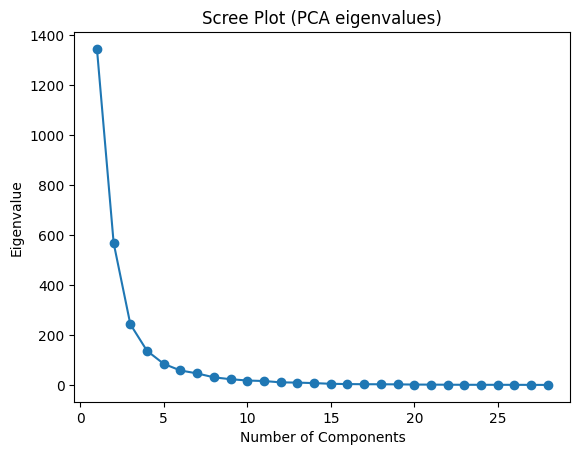

In [55]:
pca = PCA()
pca.fit(X)

ev = pca.explained_variance_

plt.plot(range(1, len(ev) + 1), ev, marker='o')
plt.title('Scree Plot (PCA eigenvalues)')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.show()

In [56]:
n_factors = 5
fa = FactorAnalysis(n_components=n_factors, random_state=0)
factor_scores = fa.fit_transform(X)

In [57]:
fa_df = pd.DataFrame(
    factor_scores,
    columns=[f'Factor{i+1}' for i in range(n_factors)],
    index=demo_occ.index
)

In [58]:
loadings = pd.DataFrame(
    fa.components_.T,
    index=predictors,
    columns=fa_df.columns
)
print("Factor Loadings:\n", loadings)

Factor Loadings:
                           Factor1    Factor2   Factor3   Factor4   Factor5
nhw21p                  -1.814386  -8.525731 -0.584304 -1.040629  9.565937
nhb21p                   1.357331   8.308842 -4.457066 -4.817136 -3.026882
h21p                     2.112164   3.696152 -0.544843 -2.394297 -1.256128
cvap21bapp              -1.264566  -5.601707  1.792869 -4.475591  9.145087
chin21p                 -8.504272  -9.475012  5.552158 -2.855044 -1.364765
kor21p                  -3.927017  -2.812388  0.562918 -0.961678  0.020042
domin21p                 0.182633   1.149654 -0.367852 -0.317140  0.051883
mex21p                   0.267311   0.234502 -0.090878 -0.378030  0.140810
white_transplant_ratio  -0.290277  -0.256222 -0.255042  0.120549  0.423033
ind21p                   7.687644   2.019694 -0.456487  5.811807  0.629581
bang21p                  0.519185   2.526645  1.182378  0.066992 -0.260493
pak21p                   0.256806   0.523468 -0.187559  0.195465 -0.351747
filip21

In [59]:
Y = demo_occ['vote_share']
model_fa = sm.OLS(Y, sm.add_constant(fa_df)).fit()
print(model_fa.summary())

                            OLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     22.50
Date:                Fri, 17 Oct 2025   Prob (F-statistic):           4.68e-15
Time:                        11:48:06   Log-Likelihood:                -356.62
No. Observations:                 106   AIC:                             725.2
Df Residuals:                     100   BIC:                             741.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.6619      0.700     33.820      0.0